In [17]:
import re
import random
import pandas as pd
import hashlib

In [18]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Asynchronous Python', 'PnP PowerShell']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [19]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Exchange Online and Defender,218.739820,5.608713,17.008374,39
Docker,317.243763,10.233670,19.010723,31
SSH + SCP,336.395094,11.599831,28.455806,29
GUI Docker Container,490.283636,23.346840,38.435417,21
Linux,806.537951,25.204311,38.835904,32
"Everything is Tuberculosis, Green",611.533283,26.588404,37.170910,23
WinHex,618.211631,29.438649,44.411882,21
"The Simulacra, Dick",850.629162,44.769956,70.840871,19
Windows PATH Variable,1440.000792,48.000026,106.098991,30
Node.JS and React,1972.926266,63.642783,155.166451,31


# Histogram

sum of ages: ~53987.57


<Axes: >

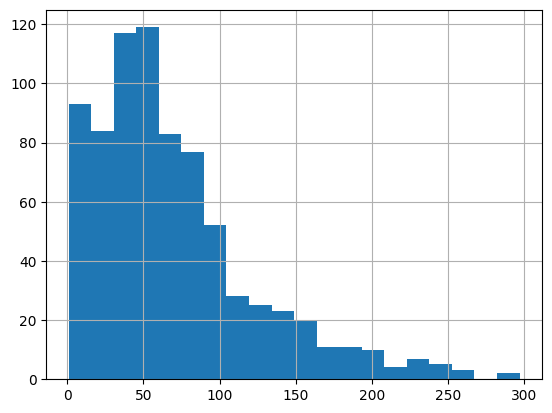

In [20]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~53987.57


<Axes: >

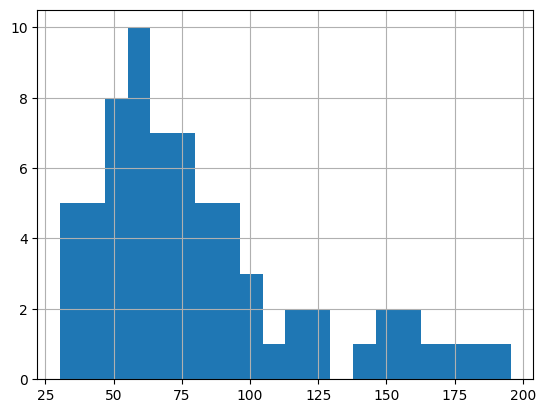

In [21]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Python']['age'].hist(bins=20)

# Completely Random Shuffle

In [22]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [23]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [24]:
n = 3
m=existing_cards.shape[0]//100
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // m

existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 774
Total card age: 53987.57


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
235,Python,Q:\nWhat parameter can be used with tqdm to se...,fa29991495d99373e2493571fe062013,-195.555542,81.729536,195.555542,-5639.338013,0.635191,69,0,0
497,Python,Q:\nHow can decorators be used to modify the b...,a09439507a2ae2c5431f7bf30e131f7b,-183.071944,81.729536,195.555542,-5639.338013,0.635191,69,1,0
751,Python,Q:\nHow can you specify that an optional argum...,db4e248337503988a4259234638518c8,-172.417447,81.729536,195.555542,-5639.338013,0.635191,69,2,0
236,Python,Q:\nHow do you handle multiple exceptions in a...,bd2b6710c593eed8d7f1ea9dd1cde465,-166.338397,81.729536,195.555542,-5639.338013,0.635191,69,3,0
752,Python,import time\nfrom contextlib import contextman...,21db986175b2ed8e2f9ac07719d86f14,-157.505900,81.729536,195.555542,-5639.338013,0.635191,69,4,0
498,Python,Q:\nHow can you add a dynamic description to a...,1c1c91aec36509ab8788a1e2ad63cda8,-156.360563,81.729536,195.555542,-5639.338013,0.635191,69,5,0
499,Python,Q:\nWhat method can be used to send a value in...,b51d4cea76f983fc7baebc4d96546e84,-149.038478,81.729536,195.555542,-5639.338013,0.635191,69,6,0
217,Azure Files Documentation,Azure File Sync enables you to centralize your...,18a7f43346e331c5420a8a211ce66fac,-184.379673,83.686273,184.379673,-4435.372482,0.161009,53,0,0
479,Azure Files Documentation,For Microsoft Entra Domain Services authentica...,c57fc1a1c082a28b95731e721709f118,-182.795257,83.686273,184.379673,-4435.372482,0.161009,53,1,0
734,Azure Files Documentation,SMB Multichannel enables file servers to use m...,4ec157a35e0287ac754b299aba4a9c7e,-177.407226,83.686273,184.379673,-4435.372482,0.161009,53,2,0


## Age Mean

In [25]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [26]:
# n = random.choice([1, 2, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [27]:
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

# choices = ['floor', 'mod']
# option = random.choice(choices)
# if option == 'floor':
#     n=5
#     existing_cards['n_fold'] = existing_cards['count'] // n
#     print("floor dividing for n-fold")
# elif option == 'mod':
#     n=3
#     existing_cards['n_fold'] = existing_cards['count'] % n
#     print("modulo for n-fold")
# else: raise NotImplementedError


# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [28]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [29]:
existing_cards.head(10)['age'].sum()

np.float64(-1724.8704273943767)

In [30]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
261,PnP PowerShell,Invoke-PnPRequest (PnP.PowerShell)\nSends cust...,76b6b1815c89739010ffb02cb0d2d6fd,-297.166578,144.570843,297.166578,-1011.995899,0.127674,7,0,0
188,Node.js and Vite,vite.config.js\nVite’s main configuration file...,6579af3b0c080942dce68776aa2d8914,-295.952876,98.013205,295.952876,-4018.541407,0.248396,41,0,0
265,Accounting,General Ledger (GL)\nCentral accounting record...,2e1cb1792a872ef7c0655341a20c8431,-265.010271,86.756013,265.010271,-1127.828174,0.409566,13,0,0
202,Microsoft Purview,"You can configure your policies so that, when ...",1bc3c328bf07dac54524eadc58cfa328,-261.950395,87.941869,261.950395,-3957.384102,0.220648,45,0,0
174,Django,Django App\nA self-contained feature module (e...,369de91dbb3f2242f251cc46ac43faac,-259.344654,83.623074,259.344654,-3344.922963,0.152899,40,0,0
3,TSQL,Q: What does SUM(x) OVER (PARTITION BY y) do?\...,dda5b7601f3b5593f784810dd25436e7,-249.117616,98.805434,249.117616,-1580.886941,0.925996,16,0,0
137,Terraform Codebox,corepack pnpm test\nA command pattern used to ...,85012d4ed6b5e32d36886a085cc48197,-246.409910,103.061794,246.409910,-3710.224578,0.710260,36,0,0
464,Microsoft Purview,"When you create your DLP policies, you should ...",8ec1edc0f421bb7de2884cb3c7089b3e,-246.360063,87.941869,261.950395,-3957.384102,0.220648,45,1,0
400,Terraform Codebox,Lifecycle blocks let you fine-tune resource be...,0f442d63063c2560ae76af631c6b9d12,-242.555212,103.061794,246.409910,-3710.224578,0.710260,36,1,0
450,Node.js and Vite,Dependency Tree\nThe hierarchy of packages you...,fe8e79ae405e0d649b489d1c407e8f9e,-239.915269,98.013205,295.952876,-4018.541407,0.248396,41,1,0


In [31]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 69.751'